In [1]:
import argparse
import logging
import math
import os
import random
from pathlib import Path

import accelerate
import datasets
import numpy as np
import torch
import torch.nn.functional as F
import torch.utils.checkpoint
import transformers
from accelerate import Accelerator
from accelerate.logging import get_logger
from accelerate.state import AcceleratorState
from accelerate.utils import ProjectConfiguration, set_seed
from datasets import load_dataset
from huggingface_hub import create_repo, upload_folder
from packaging import version
from torchvision import transforms
from tqdm.auto import tqdm
from transformers import CLIPTextModel, CLIPTokenizer
from transformers.utils import ContextManagers

import diffusers
from diffusers import AutoencoderKL, DDPMScheduler, StableDiffusionPipeline, UNet2DConditionModel
from diffusers.optimization import get_scheduler
from diffusers.training_utils import EMAModel
from diffusers.utils import check_min_version, deprecate, is_wandb_available
from diffusers.utils.import_utils import is_xformers_available

In [2]:
from PIL import Image
import torch
from transformers import CLIPTextModel, CLIPTokenizer
from diffusers import AutoencoderKL, UNet2DConditionModel, PNDMScheduler

In [3]:
result_path = "/remote-home/songtianwei/research/diffusion_model_my/sh/text-to-image/train_finetuned/my_train_results"
pretrained_path = result_path

In [4]:
# pipe = StableDiffusionPipeline.from_pretrained(result_path)
# pipe = pipe.to("cuda")    
# pipe.safety_checker = None
# pipe.requires_safety_checker = False

In [5]:
vae = AutoencoderKL.from_pretrained(pretrained_path, subfolder="vae")
tokenizer = CLIPTokenizer.from_pretrained(pretrained_path, subfolder="tokenizer")
text_encoder = CLIPTextModel.from_pretrained(pretrained_path, subfolder="text_encoder")
unet = UNet2DConditionModel.from_pretrained(pretrained_path, subfolder="unet")

In [6]:
# another Scheduler
from diffusers import UniPCMultistepScheduler

scheduler = UniPCMultistepScheduler.from_pretrained(pretrained_path, subfolder="scheduler")

In [7]:
# set device
torch_device = "cuda"
vae.to(torch_device)
text_encoder.to(torch_device)
unet.to(torch_device)

# set model to eval mode
vae.eval()
text_encoder.eval()
unet.eval()

UNet2DConditionModel(
  (conv_in): Conv2d(4, 320, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): Linear(in_features=320, out_features=1280, bias=True)
    (act): SiLU()
    (linear_2): Linear(in_features=1280, out_features=1280, bias=True)
  )
  (down_blocks): ModuleList(
    (0): CrossAttnDownBlock2D(
      (attentions): ModuleList(
        (0-1): 2 x Transformer2DModel(
          (norm): GroupNorm(32, 320, eps=1e-06, affine=True)
          (proj_in): Conv2d(320, 320, kernel_size=(1, 1), stride=(1, 1))
          (transformer_blocks): ModuleList(
            (0): BasicTransformerBlock(
              (norm1): LayerNorm((320,), eps=1e-05, elementwise_affine=True)
              (attn1): Attention(
                (to_q): Linear(in_features=320, out_features=320, bias=False)
                (to_k): Linear(in_features=320, out_features=320, bias=False)
                (to_v): Linear(in_features=320, out_fe

In [8]:
# grad set to false
vae.requires_grad_(False)
text_encoder.requires_grad_(False)
unet.requires_grad_(False)

UNet2DConditionModel(
  (conv_in): Conv2d(4, 320, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): Linear(in_features=320, out_features=1280, bias=True)
    (act): SiLU()
    (linear_2): Linear(in_features=1280, out_features=1280, bias=True)
  )
  (down_blocks): ModuleList(
    (0): CrossAttnDownBlock2D(
      (attentions): ModuleList(
        (0-1): 2 x Transformer2DModel(
          (norm): GroupNorm(32, 320, eps=1e-06, affine=True)
          (proj_in): Conv2d(320, 320, kernel_size=(1, 1), stride=(1, 1))
          (transformer_blocks): ModuleList(
            (0): BasicTransformerBlock(
              (norm1): LayerNorm((320,), eps=1e-05, elementwise_affine=True)
              (attn1): Attention(
                (to_q): Linear(in_features=320, out_features=320, bias=False)
                (to_k): Linear(in_features=320, out_features=320, bias=False)
                (to_v): Linear(in_features=320, out_fe

In [9]:
text_prompt = "A photo of a dog"

prompt = [text_prompt]*10
height = 224  # default height of Stable Diffusion
width = 224 # default width of Stable Diffusion
num_inference_steps = 100  # Number of denoising steps
guidance_scale = 7.5  # Scale for classifier-free guidance
generator = torch.manual_seed(0)  # Seed generator to create the inital latent noise
batch_size = len(prompt)

In [10]:
# generate noise
def generate_noise(prompts,type="text",norm_type="l2"):
    batch_size = len(prompts)
    if type == "text":
        text_input = tokenizer(prompts, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")  # [bs:1,seq_len:77]
    else:
        text_input = prompts
    with torch.no_grad():
        text_embeddings = text_encoder(text_input.input_ids.to(torch_device))[0]  # [bs:1,seq_len:77,embedding_dim:768]

    latents = torch.randn(
        (batch_size, unet.in_channels, height // 8, width // 8),  # here not use the recommended `config`, goes wrong
        generator=generator,
    )
    latents = latents.to(torch_device)  
    latents = latents * scheduler.init_noise_sigma
    scheduler.set_timesteps(num_inference_steps)
    
    for t in tqdm(scheduler.timesteps):
        # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
        latent_model_input = torch.cat([latents])
        # print(latent_model_input.shape)  # [bs:2, channel:4, latent_h: 64, latent_w: 64]
    
        latent_model_input = scheduler.scale_model_input(latent_model_input, timestep=t)
        # print(latent_model_input.shape)  # same shape of latent_model_input
    
        # predict the noise residual
        with torch.no_grad():
            noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample
        # print(noise_pred.shape) # same shape of latent_model_input
            
        # perform guidance
        noise_pred_text = noise_pred.chunk(2)
    
        # compute the previous noisy sample x_t -> x_t-1
        latents = scheduler.step(noise_pred, t, latents).prev_sample
        break

    noise_source = noise_pred
    with torch.no_grad():
        vae_decoding = vae.decode(noise_source).sample
    epsilon = 16
    if norm_type == 'l2':
        temp = torch.norm(vae_decoding.view(vae_decoding.shape[0], -1), dim=1).view(-1, 1, 1, 1)
        vae_decoding = vae_decoding * epsilon / temp
    elif norm_type == 'l1':
        vae_decoding = torch.clamp(vae_decoding, -epsilon / 255, epsilon / 255)
    else:
        pass
    return vae_decoding

In [11]:
# if __name__ == "__main__":
#     # generate noise
#     print("generating noise...")
#     print(generate_noise(prompt).shape)

In [12]:
noise = generate_noise(prompt,norm_type='l2')

/tmp/ipykernel_633466/2876619549.py:12: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  (batch_size, unet.in_channels, height // 8, width // 8),  # here not use the recommended `config`, goes wrong


  0%|          | 0/100 [00:00<?, ?it/s]

In [13]:
noise

tensor([[[[-0.2895, -0.2342, -0.2138,  ..., -0.2320, -0.1217, -0.1899],
          [-0.1146, -0.1613, -0.1470,  ..., -0.1719, -0.0825, -0.2074],
          [-0.0868, -0.1120, -0.0950,  ..., -0.1374, -0.0990, -0.1812],
          ...,
          [-0.0393, -0.0532, -0.0816,  ...,  0.0335,  0.0980,  0.0959],
          [-0.1134, -0.0055, -0.0459,  ...,  0.0564,  0.1090,  0.0758],
          [-0.0321, -0.0688, -0.0415,  ...,  0.0629,  0.0882,  0.0786]],

         [[-0.2199, -0.1585, -0.1419,  ..., -0.1639, -0.0763, -0.0299],
          [-0.0919, -0.1369, -0.1309,  ..., -0.1557, -0.0711, -0.1249],
          [-0.1471, -0.1145, -0.1218,  ..., -0.1121, -0.0745, -0.1186],
          ...,
          [-0.0821, -0.0650, -0.0997,  ...,  0.0586,  0.0869,  0.0770],
          [-0.1122, -0.0797, -0.0739,  ...,  0.0614,  0.0706,  0.0322],
          [-0.0327, -0.0602, -0.0387,  ...,  0.0233,  0.0382,  0.0121]],

         [[-0.1192, -0.0924, -0.0867,  ..., -0.1333, -0.0825, -0.0665],
          [-0.0104, -0.1251, -

In [14]:
from transformers import CLIPModel

clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
clip_model.requires_grad_(False)

CLIPModel(
  (text_model): CLIPTextTransformer(
    (embeddings): CLIPTextEmbeddings(
      (token_embedding): Embedding(49408, 512)
      (position_embedding): Embedding(77, 512)
    )
    (encoder): CLIPEncoder(
      (layers): ModuleList(
        (0-11): 12 x CLIPEncoderLayer(
          (self_attn): CLIPAttention(
            (k_proj): Linear(in_features=512, out_features=512, bias=True)
            (v_proj): Linear(in_features=512, out_features=512, bias=True)
            (q_proj): Linear(in_features=512, out_features=512, bias=True)
            (out_proj): Linear(in_features=512, out_features=512, bias=True)
          )
          (layer_norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (mlp): CLIPMLP(
            (activation_fn): QuickGELUActivation()
            (fc1): Linear(in_features=512, out_features=2048, bias=True)
            (fc2): Linear(in_features=2048, out_features=512, bias=True)
          )
          (layer_norm2): LayerNorm((512,), eps=1e-05,

In [5]:
args = argparse.Namespace(
    input_pertubation=0.1,
    pretrained_model_name_or_path="runwayml/stable-diffusion-v1-5",
    revision=None,
    dataset_name="ydshieh/coco_dataset_script",
    dataset_config_name="2017",
    data_dir="/remote-home/songtianwei/research/diffusion_model_my/data",
    train_data_dir=None,
    image_column="image",
    caption_column="text",
    max_train_samples=None,
    validation_prompts=None,
    output_dir="sd-pokemon-model",
    cache_dir=None,
    seed=None,
    resolution=512,
    center_crop=False,
    random_flip=False,
    train_batch_size=1,
    num_train_epochs=100,
    max_train_steps=15000,
    gradient_accumulation_steps=1,
    gradient_checkpointing=False,
    learning_rate=1e-05,
    scale_lr=False,
    lr_scheduler="constant",
    lr_warmup_steps=0,
    snr_gamma=None,
    use_8bit_adam=False,
    allow_tf32=False,
    use_ema=False,
    non_ema_revision=None,
    dataloader_num_workers=0,
    adam_beta1=0.9,
    adam_beta2=0.999,
    adam_weight_decay=1e-2,
    adam_epsilon=1e-08,
    max_grad_norm=1.0,
    push_to_hub=False,
    hub_token=None,
    hub_model_id=None,
    logging_dir="logs",
    mixed_precision="fp16",
    report_to="tensorboard",
    local_rank=-1,
    checkpointing_steps=500,
    checkpoints_total_limit=None,
    resume_from_checkpoint=None,
    enable_xformers_memory_efficient_attention=True,
    noise_offset=0,
    validation_epochs=5,
    tracker_project_name="text2image-fine-tune"
)


In [16]:
dataset = load_dataset(
            args.dataset_name,
            name=args.dataset_config_name,
            splits=None,
            cache_dir=args.cache_dir,
            data_dir=args.data_dir,
        )

Found cached dataset coco_dataset_script (/remote-home/songtianwei/.cache/huggingface/datasets/ydshieh___coco_dataset_script/2017-04502b97a2b36df4/0.0.0/e033205c0266a54c10be132f9264f2a39dcf893e798f6756d224b1ff5078998f)


  0%|          | 0/3 [00:00<?, ?it/s]

In [17]:
dataset

DatasetDict({
    train: Dataset({
        features: ['image_id', 'caption_id', 'caption', 'height', 'width', 'file_name', 'coco_url', 'image_path'],
        num_rows: 591753
    })
    validation: Dataset({
        features: ['image_id', 'caption_id', 'caption', 'height', 'width', 'file_name', 'coco_url', 'image_path'],
        num_rows: 25014
    })
    test: Dataset({
        features: ['image_id', 'caption_id', 'caption', 'height', 'width', 'file_name', 'coco_url', 'image_path'],
        num_rows: 40670
    })
})

In [18]:
train_dataset,val_dataset,test_dataset = dataset['train'],dataset['validation'],dataset['test']

In [19]:
print(len(train_dataset))
for data in train_dataset:
    print(data)
    break

591753
{'image_id': 203564, 'caption_id': 37, 'caption': 'A bicycle replica with a clock as the front wheel.', 'height': 400, 'width': 400, 'file_name': '000000203564.jpg', 'coco_url': 'http://images.cocodataset.org/train2017/000000203564.jpg', 'image_path': '/remote-home/songtianwei/.cache/huggingface/datasets/downloads/extracted/2eaa9620da3c5978de7bf66708380d3175d70ab7bb370443574b53d85fe1ebf0/train2017/000000203564.jpg'}


In [20]:
print(len(val_dataset))
for data in val_dataset:
    print(data)
    break

25014
{'image_id': 179765, 'caption_id': 38, 'caption': 'A black Honda motorcycle parked in front of a garage.', 'height': 480, 'width': 640, 'file_name': '000000179765.jpg', 'coco_url': 'http://images.cocodataset.org/val2017/000000179765.jpg', 'image_path': '/remote-home/songtianwei/.cache/huggingface/datasets/downloads/extracted/7cca5caa6ce0f148fbc8eba9560296eac3612ce73e20ae59e5e4becfea22b44c/val2017/000000179765.jpg'}


In [21]:
for idx,data in enumerate(test_dataset):
    # test_dataset has no captions
    print(data)
    if idx >20:
        break

{'image_id': 466319, 'caption_id': -1, 'caption': '-1', 'height': 480, 'width': 640, 'file_name': '000000466319.jpg', 'coco_url': 'http://images.cocodataset.org/test2017/000000466319.jpg', 'image_path': '/remote-home/songtianwei/.cache/huggingface/datasets/downloads/extracted/7227ca4241acdb9127e3623d18e6e5ccf27240348f6aff539de8cef79704399e/test2017/000000466319.jpg'}
{'image_id': 523573, 'caption_id': -1, 'caption': '-1', 'height': 500, 'width': 423, 'file_name': '000000523573.jpg', 'coco_url': 'http://images.cocodataset.org/test2017/000000523573.jpg', 'image_path': '/remote-home/songtianwei/.cache/huggingface/datasets/downloads/extracted/7227ca4241acdb9127e3623d18e6e5ccf27240348f6aff539de8cef79704399e/test2017/000000523573.jpg'}
{'image_id': 308929, 'caption_id': -1, 'caption': '-1', 'height': 640, 'width': 425, 'file_name': '000000308929.jpg', 'coco_url': 'http://images.cocodataset.org/test2017/000000308929.jpg', 'image_path': '/remote-home/songtianwei/.cache/huggingface/datasets/dow

In [22]:
image_column = "image_path" 

In [23]:
caption_column = "caption"

In [24]:
def tokenize_captions(examples, is_train=True):
        captions = []
        for caption in examples[caption_column]:
            if isinstance(caption, str):
                captions.append(caption)
            elif isinstance(caption, (list, np.ndarray)):
                # take a random caption if there are multiple
                captions.append(random.choice(caption) if is_train else caption[0])
            else:
                raise ValueError(
                    f"Caption column `{caption_column}` should contain either strings or lists of strings."
                )
        inputs = tokenizer(
            captions, max_length=tokenizer.model_max_length, padding="max_length", truncation=True, return_tensors="pt"
        )
        return inputs.input_ids


In [25]:
def filter_corrupt_images(examples):
    """remove problematic images"""
    valid_images = []
    for image_file in examples[image_column]:
        try:
            Image.open(image_file).convert("RGB") 
            valid_images.append(True)
        except Exception:
            valid_images.append(False)
    return valid_images

In [26]:
val_dataset = val_dataset.filter(filter_corrupt_images,batched=True)

Loading cached processed dataset at /remote-home/songtianwei/.cache/huggingface/datasets/ydshieh___coco_dataset_script/2017-04502b97a2b36df4/0.0.0/e033205c0266a54c10be132f9264f2a39dcf893e798f6756d224b1ff5078998f/cache-96d701beeed8d0c5.arrow


In [27]:
train_transforms = transforms.Compose(
        [
            transforms.Resize(args.resolution, interpolation=transforms.InterpolationMode.BILINEAR),
            transforms.CenterCrop(args.resolution) if args.center_crop else transforms.RandomCrop(args.resolution),
            transforms.RandomHorizontalFlip() if args.random_flip else transforms.Lambda(lambda x: x),
            transforms.ToTensor(),
            transforms.Normalize([0.5], [0.5]),
        ]
    )

In [28]:
def preprocess_train(examples):
        from PIL import Image
        # print(examples[image_column])
        # print(examples[image_column][0])
        # print(type(examples[image_column][0]))
        # print(examples[image_column][0]=="str")
        if isinstance(examples[image_column][0],str):
            # For coco dataset, the images are loaded as path
            # images = [read_image(image_file, mode=ImageReadMode.RGB) for image_file in examples[image_column]]
            images = [Image.open(image_file).convert("RGB") for image_file in examples[image_column]]
        else:
            # lambdalabs/pokemon-blip-captions
            images = [image.convert("RGB") for image in examples[image_column]]
        examples["pixel_values"] = [train_transforms(image) for image in images]
        examples["input_ids"] = tokenize_captions(examples)
        return examples

In [29]:
val_dataset = val_dataset.with_transform(preprocess_train)

In [30]:
print(len(val_dataset))
for data in val_dataset:
    print(data)
    break

25014
{'image_id': 179765, 'caption_id': 38, 'caption': 'A black Honda motorcycle parked in front of a garage.', 'height': 480, 'width': 640, 'file_name': '000000179765.jpg', 'coco_url': 'http://images.cocodataset.org/val2017/000000179765.jpg', 'image_path': '/remote-home/songtianwei/.cache/huggingface/datasets/downloads/extracted/7cca5caa6ce0f148fbc8eba9560296eac3612ce73e20ae59e5e4becfea22b44c/val2017/000000179765.jpg', 'pixel_values': tensor([[[-0.4196, -0.4275, -0.4039,  ...,  0.9922,  0.9922,  1.0000],
         [-0.5529, -0.5373, -0.5137,  ...,  0.9922,  0.9922,  1.0000],
         [-0.6314, -0.6314, -0.6314,  ...,  1.0000,  0.9922,  1.0000],
         ...,
         [-0.3804, -0.3098, -0.2941,  ...,  0.3412,  0.2157,  0.0824],
         [-0.3569, -0.1451, -0.3490,  ..., -0.0902, -0.2706, -0.4039],
         [-0.2235, -0.3882, -0.6000,  ..., -0.3412, -0.3255, -0.3804]],

        [[-0.3569, -0.3647, -0.3412,  ...,  0.9922,  0.9922,  1.0000],
         [-0.4980, -0.4824, -0.4588,  ...,  0.

In [32]:
def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    pixel_values = pixel_values.to(memory_format=torch.contiguous_format).float()
    input_ids = torch.stack([example["input_ids"] for example in examples])
    return {"pixel_values": pixel_values, "input_ids": input_ids}


In [38]:
eval_dataset = dataset['validation']
eval_dataset = eval_dataset.filter(filter_corrupt_images,batched=True)
eval_dataset = eval_dataset.with_transform(preprocess_train)
# eval dataloader 

eval_dataloader = torch.utils.data.DataLoader(
    eval_dataset,
    shuffle=True,
    collate_fn=collate_fn,
    batch_size=6,
    num_workers=args.dataloader_num_workers,
)

Loading cached processed dataset at /remote-home/songtianwei/.cache/huggingface/datasets/ydshieh___coco_dataset_script/2017-04502b97a2b36df4/0.0.0/e033205c0266a54c10be132f9264f2a39dcf893e798f6756d224b1ff5078998f/cache-96d701beeed8d0c5.arrow


In [39]:
args.train_batch_size

1

In [46]:
for data in eval_dataloader:
    pixel_values = data['pixel_values']
    print(pixel_values.shape)
    break

torch.Size([6, 3, 512, 512])


In [42]:
unet.eval()
vae.decoder.eval()
eval_loss = 0.0
            

In [48]:
weight_dtype = torch.float32

In [50]:
noise_scheduler = DDPMScheduler.from_pretrained(args.pretrained_model_name_or_path, subfolder="scheduler")

In [52]:
eval_dataloader = accelerator.prepare(eval_dataloader)


NameError: name 'accelerator' is not defined

In [51]:
for batch in eval_dataloader:
    # Convert images to latent space
    img_pixel_values = batch["pixel_values"].to(weight_dtype)
    
    # here you can not access the img, so set it random
    # latents = vae.encode(img_pixel_values).latent_dist.sample()
    latents = torch.randn_like(img_pixel_values).to(weight_dtype)
    latents = latents * vae.config.scaling_factor
    
    # Sample noise that we'll add to the latents
    noise = torch.randn_like(latents)
    
    if args.input_pertubation:
        new_noise = noise + args.input_pertubation * torch.randn_like(noise)
    bsz = latents.shape[0]
    # Sample a random timestep for each image
    timesteps = torch.randint(0, noise_scheduler.config.num_train_timesteps, (bsz,), device=latents.device)
    timesteps = timesteps.long()
    
    # Add noise to the latents according to the noise magnitude at each timestep
    # (this is the forward diffusion process)
    if args.input_pertubation:
        noisy_latents = noise_scheduler.add_noise(latents, new_noise, timesteps)
    else:
        noisy_latents = noise_scheduler.add_noise(latents, noise, timesteps)
    
    # Get the text embedding for conditioning
    batch_token_ids = batch["input_ids"]
    encoder_hidden_states = text_encoder(batch_token_ids)[0]
    
    # Get the target for loss depending on the prediction type
    if noise_scheduler.config.prediction_type == "epsilon":
        target = noise
    elif noise_scheduler.config.prediction_type == "v_prediction":
        target = noise_scheduler.get_velocity(latents, noise, timesteps)
    else:
        raise ValueError(f"Unknown prediction type {noise_scheduler.config.prediction_type}")
    
    # Predict the noise residual and compute loss
    # noise_latents : image latent with noise 
    # encoder_hidden_state : text latent data
    model_pred = unet(noisy_latents, timesteps, encoder_hidden_states).sample
    
    # START MY CODE
    vae_decoding = vae.decode(model_pred).sample  # use vae output as noise
    
    # limit the norm of the noise
    norm_type = 'l2'
    epsilon = 16
    if norm_type == 'l2':
        temp = torch.norm(vae_decoding.view(vae_decoding.shape[0], -1), dim=1).view(-1, 1, 1, 1)
        vae_decoding = vae_decoding * epsilon / temp
    else:
        vae_decoding = torch.clamp(vae_decoding, -epsilon / 255, epsilon / 255)
    image_noise = img_pixel_values + vae_decoding
    image_noise = torch.clamp(image_noise, -1, 1)
    
    # align the image_noise embedding with the text
    image_features = clip_model.get_image_features(image_noise)
    text_features = clip_model.get_text_features(batch_token_ids)
    
    logits_per_image, logits_per_text = cal_sim(text_features,image_features)
    # softmax
    loss = torch.nn.functional.softmax(logits_per_image, dim=0)
    # sum the logits of the 对角线
    loss = torch.diag(logits_per_image).mean()
    # evaluation loss should be large for clip model when calculating the similarity
    
    logs = {"eval_loss": loss.detach().item(), "lr": lr_scheduler.get_last_lr()[0]}
    progress_bar.set_postfix(**logs)

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu! (when checking argument for argument index in method wrapper_CUDA__index_select)

In [6]:
from transformers import CLIPModel

In [7]:
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
clip_model.requires_grad_(False)


CLIPModel(
  (text_model): CLIPTextTransformer(
    (embeddings): CLIPTextEmbeddings(
      (token_embedding): Embedding(49408, 512)
      (position_embedding): Embedding(77, 512)
    )
    (encoder): CLIPEncoder(
      (layers): ModuleList(
        (0-11): 12 x CLIPEncoderLayer(
          (self_attn): CLIPAttention(
            (k_proj): Linear(in_features=512, out_features=512, bias=True)
            (v_proj): Linear(in_features=512, out_features=512, bias=True)
            (q_proj): Linear(in_features=512, out_features=512, bias=True)
            (out_proj): Linear(in_features=512, out_features=512, bias=True)
          )
          (layer_norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (mlp): CLIPMLP(
            (activation_fn): QuickGELUActivation()
            (fc1): Linear(in_features=512, out_features=2048, bias=True)
            (fc2): Linear(in_features=2048, out_features=512, bias=True)
          )
          (layer_norm2): LayerNorm((512,), eps=1e-05,

In [8]:
image_noise = torch.ones((6,3,224,224))

In [9]:
batch_token_ids = torch.ones((6,77),dtype=torch.int)
print(batch_token_ids.dtype)

torch.int32


In [10]:
data_input = {
    "input_ids":batch_token_ids,
    "pixel_values" : image_noise
}

In [11]:
output = clip_model.forward(**data_input,return_loss=True)

In [12]:
logits_per_image = output.logits_per_image  # this is the image-text similarity score
probs = logits_per_image.softmax(dim=1)  # we can take the softmax to get the label probabilities

In [13]:
probs

tensor([[0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.1667],
        [0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.1667],
        [0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.1667],
        [0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.1667],
        [0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.1667],
        [0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.1667]])

In [14]:
logits_per_text = output.logits_per_text
probs = logits_per_text.softmax(dim=1) 
print(probs)

tensor([[0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.1667],
        [0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.1667],
        [0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.1667],
        [0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.1667],
        [0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.1667],
        [0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.1667]])


In [15]:
print(output.keys())

odict_keys(['loss', 'logits_per_image', 'logits_per_text', 'text_embeds', 'image_embeds', 'text_model_output', 'vision_model_output'])


In [16]:
loss = output.loss

In [17]:
print(loss)

tensor(1.7918)


In [18]:
clip_model.forward?

Signature:
clip_model.forward(
    input_ids: Union[torch.LongTensor, NoneType] = None,
    pixel_values: Union[torch.FloatTensor, NoneType] = None,
    attention_mask: Union[torch.Tensor, NoneType] = None,
    position_ids: Union[torch.LongTensor, NoneType] = None,
    return_loss: Union[bool, NoneType] = None,
    output_attentions: Union[bool, NoneType] = None,
    output_hidden_states: Union[bool, NoneType] = None,
    return_dict: Union[bool, NoneType] = None,
) -> Union[Tuple, transformers.models.clip.modeling_clip.CLIPOutput]
Docstring:
The [`CLIPModel`] forward method, overrides the `__call__` special method.

<Tip>

Although the recipe for forward pass needs to be defined within this function, one should call the [`Module`]
instance afterwards instead of this since the former takes care of running the pre and post processing steps while
the latter silently ignores them.

</Tip>

Args:
    input_ids (`torch.LongTensor` of shape `(batch_size, sequence_length)`):
        Indices 

In [4]:
from PIL import Image
import requests
from transformers import AutoProcessor, CLIPModel

In [5]:
model_pretrained = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")

In [6]:
model_config = model_pretrained.config

In [7]:
print(model_config)

CLIPConfig {
  "_commit_hash": "e6a30b603a447e251fdaca1c3056b2a16cdfebeb",
  "_name_or_path": "openai/clip-vit-base-patch32",
  "architectures": [
    "CLIPModel"
  ],
  "initializer_factor": 1.0,
  "logit_scale_init_value": 2.6592,
  "model_type": "clip",
  "projection_dim": 512,
  "text_config": {
    "_name_or_path": "",
    "add_cross_attention": false,
    "architectures": null,
    "attention_dropout": 0.0,
    "bad_words_ids": null,
    "begin_suppress_tokens": null,
    "bos_token_id": 0,
    "chunk_size_feed_forward": 0,
    "cross_attention_hidden_size": null,
    "decoder_start_token_id": null,
    "diversity_penalty": 0.0,
    "do_sample": false,
    "dropout": 0.0,
    "early_stopping": false,
    "encoder_no_repeat_ngram_size": 0,
    "eos_token_id": 2,
    "exponential_decay_length_penalty": null,
    "finetuning_task": null,
    "forced_bos_token_id": null,
    "forced_eos_token_id": null,
    "hidden_act": "quick_gelu",
    "hidden_size": 512,
    "id2label": {
      "

In [10]:
model_untrained = CLIPModel(model_config)

In [11]:
processor = AutoProcessor.from_pretrained("openai/clip-vit-base-patch32")

In [12]:
url = "http://images.cocodataset.org/val2017/000000039769.jpg"

In [13]:
image = Image.open(requests.get(url, stream=True).raw)

In [9]:
vae =  AutoencoderKL.from_pretrained(
        "CompVis/stable-diffusion-v1-4", subfolder="vae"
    )

In [10]:
vae.config

FrozenDict([('in_channels', 3),
            ('out_channels', 3),
            ('down_block_types',
             ['DownEncoderBlock2D',
              'DownEncoderBlock2D',
              'DownEncoderBlock2D',
              'DownEncoderBlock2D']),
            ('up_block_types',
             ['UpDecoderBlock2D',
              'UpDecoderBlock2D',
              'UpDecoderBlock2D',
              'UpDecoderBlock2D']),
            ('block_out_channels', [128, 256, 512, 512]),
            ('layers_per_block', 2),
            ('act_fn', 'silu'),
            ('latent_channels', 4),
            ('norm_num_groups', 32),
            ('sample_size', 512),
            ('scaling_factor', 0.18215),
            ('_class_name', 'AutoencoderKL'),
            ('_diffusers_version', '0.2.2'),
            ('_name_or_path', 'CompVis/stable-diffusion-v1-4')])

In [12]:
myVae = AutoencoderKL(**vae.config)

In [13]:
myVae

AutoencoderKL(
  (encoder): Encoder(
    (conv_in): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (down_blocks): ModuleList(
      (0): DownEncoderBlock2D(
        (resnets): ModuleList(
          (0-1): 2 x ResnetBlock2D(
            (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
            (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (norm2): GroupNorm(32, 128, eps=1e-06, affine=True)
            (dropout): Dropout(p=0.0, inplace=False)
            (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (nonlinearity): SiLU()
          )
        )
        (downsamplers): ModuleList(
          (0): Downsample2D(
            (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2))
          )
        )
      )
      (1): DownEncoderBlock2D(
        (resnets): ModuleList(
          (0): ResnetBlock2D(
            (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
            (c

In [14]:
processor??

Signature:      processor(text=None, images=None, return_tensors=None, **kwargs)
Type:           CLIPProcessor
String form:   
CLIPProcessor:
- image_processor: CLIPImageProcessor {
  "crop_size": {
    "height": 224,
    "width": 224
  },
  "do_center_crop": true,
  "do_convert_rgb": true,
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "feature_extractor_type": "CLIPFeatureExtractor",
  "image_mean": [
    0.48145466,
    0.4578275,
    0.40821073
  ],
  "image_processor_type": "CLIPImageProcessor",
  "image_std": [
    0.26862954,
    0.26130258,
    0.27577711
  ],
  "resample": 3,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "shortest_edge": 224
  }
}

- tokenizer: CLIPTokenizerFast(name_or_path='openai/clip-vit-base-patch32', vocab_size=49408, model_max_length=77, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': AddedToken("<|startoftext|>", rstrip=False, lstrip=False, single_word=False, normalized=True), '

In [15]:
processor.image_processor.image_mean

[0.48145466, 0.4578275, 0.40821073]

In [16]:
inputs = processor(
 text=["a photo of a cat", "a photo of a dog"], images=[image,image], return_tensors="pt", padding=True
)

In [28]:
inputs.keys()

dict_keys(['input_ids', 'attention_mask', 'pixel_values'])

In [70]:
inputs["pixel_values"]

tensor([[[[ 0.5873,  0.5873,  0.6165,  ...,  0.0617,  0.0471, -0.0259],
          [ 0.5727,  0.5727,  0.6603,  ...,  0.1201,  0.0763,  0.0909],
          [ 0.5873,  0.5435,  0.6165,  ...,  0.0325,  0.1201,  0.0617],
          ...,
          [ 1.8719,  1.8573,  1.8719,  ...,  1.3902,  1.4340,  1.4194],
          [ 1.8281,  1.8719,  1.8427,  ...,  1.4486,  1.4340,  1.5070],
          [ 1.8573,  1.9011,  1.8281,  ...,  1.3756,  1.3610,  1.4486]],

         [[-1.3169, -1.3019, -1.3169,  ..., -1.4970, -1.4369, -1.4820],
          [-1.2418, -1.2718, -1.2268,  ..., -1.4369, -1.4669, -1.4519],
          [-1.2568, -1.3169, -1.2268,  ..., -1.4669, -1.4069, -1.4519],
          ...,
          [ 0.1239,  0.1089,  0.1239,  ..., -0.7016, -0.6865, -0.6865],
          [ 0.0789,  0.0939,  0.0488,  ..., -0.6565, -0.6865, -0.6115],
          [ 0.0939,  0.1089,  0.0038,  ..., -0.7766, -0.7316, -0.6115]],

         [[-0.4848, -0.4137, -0.3853,  ..., -0.9541, -0.8545, -0.8545],
          [-0.4137, -0.4706, -

In [17]:
outputs = model_pretrained(**inputs,return_loss=True)

In [21]:
outputs.loss

tensor(1.6654, grad_fn=<DivBackward0>)

In [22]:
output_untrained = model_untrained(**inputs,return_loss=True)

In [24]:
output_untrained.loss

tensor(0.6932, grad_fn=<DivBackward0>)

In [22]:
inputs.pop('attention_mask')

tensor([[1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1]])

In [26]:
data_input

{'input_ids': tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1

In [31]:
input_ids = inputs["input_ids"]
pixel_values =  inputs["pixel_values"]
print(input_ids.shape)
print(input_ids.dtype)
print(pixel_values.shape)

torch.Size([2, 7])
torch.int64
torch.Size([2, 3, 224, 224])


In [32]:
outputs = clip_model(**inputs)

In [33]:

processor = AutoProcessor.from_pretrained("openai/clip-vit-base-patch32")
image_processor = processor.image_processor
image_mean = image_processor.image_mean
image_std = image_processor.image_std
# normilaze function 
def normalize_fn(x, mean=image_mean, std=image_std):
    return transforms.Normalize(mean=mean, std=std)(x)

In [14]:
from torchvision import transforms

train_transforms = transforms.Compose(
        [
            transforms.Resize(224, interpolation=transforms.InterpolationMode.BILINEAR),
            transforms.CenterCrop(224),
            transforms.RandomHorizontalFlip() if args.random_flip else transforms.Lambda(lambda x: x),
            transforms.ToTensor(),
            # transforms.Normalize([0.5], [0.5]),
        ]
    )

NameError: name 'args' is not defined

In [59]:
image = Image.open(requests.get(url, stream=True).raw)

In [60]:
print(type(image))

<class 'PIL.JpegImagePlugin.JpegImageFile'>


In [61]:
image_tensor = train_transforms(image)

In [62]:
image_tensor

tensor([[[0.6392, 0.6431, 0.6471,  ..., 0.4980, 0.4941, 0.4784],
         [0.6392, 0.6392, 0.6588,  ..., 0.5059, 0.5020, 0.5059],
         [0.6392, 0.6314, 0.6431,  ..., 0.4902, 0.5098, 0.4980],
         ...,
         [0.9843, 0.9804, 0.9843,  ..., 0.8549, 0.8627, 0.8667],
         [0.9765, 0.9843, 0.9804,  ..., 0.8706, 0.8667, 0.8824],
         [0.9843, 0.9922, 0.9725,  ..., 0.8549, 0.8471, 0.8706]],

        [[0.1098, 0.1176, 0.1176,  ..., 0.0706, 0.0784, 0.0706],
         [0.1294, 0.1255, 0.1373,  ..., 0.0784, 0.0745, 0.0784],
         [0.1294, 0.1176, 0.1333,  ..., 0.0745, 0.0902, 0.0784],
         ...,
         [0.4902, 0.4863, 0.4863,  ..., 0.2745, 0.2784, 0.2824],
         [0.4784, 0.4824, 0.4706,  ..., 0.2824, 0.2784, 0.2980],
         [0.4824, 0.4824, 0.4627,  ..., 0.2588, 0.2667, 0.2980]],

        [[0.2745, 0.2941, 0.3020,  ..., 0.1490, 0.1725, 0.1725],
         [0.2980, 0.2863, 0.3059,  ..., 0.1804, 0.1725, 0.1882],
         [0.3137, 0.2902, 0.3020,  ..., 0.1725, 0.1843, 0.

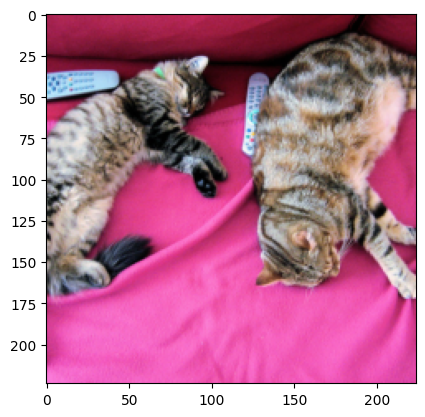

In [64]:
from torchvision import transforms
from matplotlib import pyplot as plt

plt.imshow(image_tensor.permute(1,2,0))

In [68]:
image_tensor_norm = normalize_fn(image_tensor)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


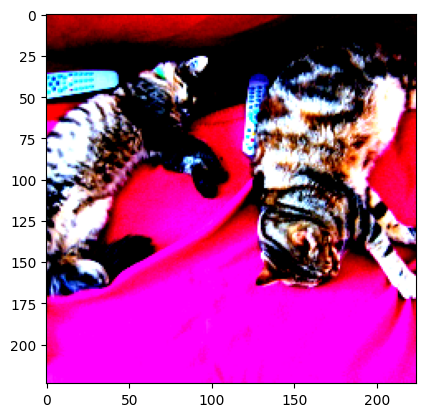

In [69]:
plt.imshow(image_tensor_norm.permute(1,2,0))

In [44]:
image_tensor_norm

tensor([[[ 0.5873,  0.6019,  0.6165,  ...,  0.0617,  0.0471, -0.0113],
         [ 0.5873,  0.5873,  0.6603,  ...,  0.0909,  0.0763,  0.0909],
         [ 0.5873,  0.5581,  0.6019,  ...,  0.0325,  0.1055,  0.0617],
         ...,
         [ 1.8719,  1.8573,  1.8719,  ...,  1.3902,  1.4194,  1.4340],
         [ 1.8427,  1.8719,  1.8573,  ...,  1.4486,  1.4340,  1.4924],
         [ 1.8719,  1.9011,  1.8281,  ...,  1.3902,  1.3610,  1.4486]],

        [[-1.3319, -1.3019, -1.3019,  ..., -1.4820, -1.4519, -1.4820],
         [-1.2568, -1.2718, -1.2268,  ..., -1.4519, -1.4669, -1.4519],
         [-1.2568, -1.3019, -1.2418,  ..., -1.4669, -1.4069, -1.4519],
         ...,
         [ 0.1239,  0.1089,  0.1089,  ..., -0.7016, -0.6865, -0.6715],
         [ 0.0789,  0.0939,  0.0488,  ..., -0.6715, -0.6865, -0.6115],
         [ 0.0939,  0.0939,  0.0188,  ..., -0.7616, -0.7316, -0.6115]],

        [[-0.4848, -0.4137, -0.3853,  ..., -0.9399, -0.8545, -0.8545],
         [-0.3995, -0.4422, -0.3711,  ..., -0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


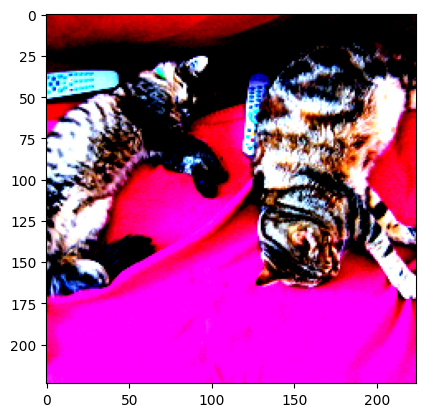

In [67]:

plt.imshow(inputs["pixel_values"][0].permute(1,2,0))

In [1]:
import argparse
import logging
import math
import os
import random
from pathlib import Path

import accelerate
import datasets
import numpy as np
import torch
import torch.nn.functional as F
import torch.utils.checkpoint
import transformers
from accelerate import Accelerator
from accelerate.logging import get_logger
from accelerate.state import AcceleratorState
from accelerate.utils import ProjectConfiguration, set_seed
from datasets import load_dataset
from huggingface_hub import create_repo, upload_folder
from packaging import version
from torchvision import transforms
from tqdm.auto import tqdm
from transformers import CLIPTextModel, CLIPTokenizer
from transformers.utils import ContextManagers

import diffusers
from diffusers import AutoencoderKL, DDPMScheduler, StableDiffusionPipeline, UNet2DConditionModel
from diffusers.optimization import get_scheduler
from diffusers.training_utils import EMAModel
from diffusers.utils import check_min_version, deprecate, is_wandb_available
from diffusers.utils.import_utils import is_xformers_available

result_path = "/remote-home/songtianwei/research/diffusion_model_my/generator/my_train_results/ydshieh/coco_dataset_script/2023-07-27/"
pretrained_path = result_path

In [2]:

from PIL import Image
import torch
from transformers import CLIPTextModel, CLIPTokenizer
from diffusers import AutoencoderKL, UNet2DConditionModel, PNDMScheduler

vae = AutoencoderKL.from_pretrained(pretrained_path, subfolder="vae")
tokenizer = CLIPTokenizer.from_pretrained(pretrained_path, subfolder="tokenizer")
text_encoder = CLIPTextModel.from_pretrained(pretrained_path, subfolder="text_encoder")
unet = UNet2DConditionModel.from_pretrained(pretrained_path, subfolder="unet")

In [3]:

# set device
torch_device = "cuda"
vae.to(torch_device)
text_encoder.to(torch_device)
unet.to(torch_device)

# set model to eval mode
vae.eval()
text_encoder.eval()
unet.eval()

# grad set to false
vae.requires_grad_(False)
text_encoder.requires_grad_(False)
unet.requires_grad_(False)


UNet2DConditionModel(
  (conv_in): Conv2d(4, 320, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): Linear(in_features=320, out_features=1280, bias=True)
    (act): SiLU()
    (linear_2): Linear(in_features=1280, out_features=1280, bias=True)
  )
  (down_blocks): ModuleList(
    (0): CrossAttnDownBlock2D(
      (attentions): ModuleList(
        (0-1): 2 x Transformer2DModel(
          (norm): GroupNorm(32, 320, eps=1e-06, affine=True)
          (proj_in): Conv2d(320, 320, kernel_size=(1, 1), stride=(1, 1))
          (transformer_blocks): ModuleList(
            (0): BasicTransformerBlock(
              (norm1): LayerNorm((320,), eps=1e-05, elementwise_affine=True)
              (attn1): Attention(
                (to_q): Linear(in_features=320, out_features=320, bias=False)
                (to_k): Linear(in_features=320, out_features=320, bias=False)
                (to_v): Linear(in_features=320, out_fe

In [4]:

text_prompt = "A photo of a dog"

prompt = [text_prompt]*10
height = 224  # default height of Stable Diffusion
width = 224 # default width of Stable Diffusion
num_inference_steps = 100  # Number of denoising steps
guidance_scale = 7.5  # Scale for classifier-free guidance
generator = torch.manual_seed(0)  # Seed generator to create the inital latent noise
batch_size = len(prompt)

In [5]:
prompts = prompt

In [8]:
batch_size = len(prompts)

text_input = tokenizer(prompts, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")  # [bs:1,seq_len:77]

with torch.no_grad():
    text_embeddings = text_encoder(text_input.input_ids.to(torch_device))[0]  # [bs:1,seq_len:77,embedding_dim:768]

latents = torch.randn(
    (batch_size, unet.in_channels, height // 8, width // 8),  # here not use the recommended `config`, goes wrong
    generator=generator,
)

/tmp/ipykernel_1163689/4096024873.py:9: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  (batch_size, unet.in_channels, height // 8, width // 8),  # here not use the recommended `config`, goes wrong


In [9]:
latents = latents.to(torch_device)  

In [10]:
latent_model_input = torch.cat([latents])

In [11]:
t =0

In [14]:
latent_model_input

tensor([[[[-1.1258e+00, -1.1524e+00, -2.5058e-01,  ..., -5.8550e-01,
           -1.7340e-01,  1.8348e-01],
          [ 1.3894e+00,  1.5863e+00,  9.4630e-01,  ..., -3.9175e-01,
            5.4329e-01, -3.9516e-01],
          [-4.4622e-01,  7.4402e-01,  1.5210e+00,  ...,  6.8705e-01,
           -8.3832e-01,  8.9182e-04],
          ...,
          [ 1.8480e+00, -2.3950e+00,  4.0770e-01,  ..., -1.3320e+00,
            1.5451e+00,  4.0863e-01],
          [-2.0546e+00,  5.2591e-01,  5.9946e-01,  ...,  6.9256e-01,
            1.1982e+00,  1.3167e+00],
          [-3.4832e-01,  1.2075e+00, -6.4783e-01,  ..., -1.5825e+00,
           -5.8779e-01, -1.1398e-01]],

         [[ 7.0144e-01, -5.5561e-01, -3.8169e-01,  ..., -2.9783e-01,
            2.1293e+00,  5.0273e-01],
          [-8.8709e-01,  1.9974e+00, -1.6984e+00,  ..., -6.0556e-01,
           -1.8824e-01,  9.5961e-01],
          [ 6.8001e-01, -7.6922e-01, -7.2884e-02,  ..., -8.1077e-01,
           -1.1052e+00, -7.2331e-01],
          ...,
     

In [15]:
text_embeddings

tensor([[[-3.8838e-01,  2.2944e-02, -5.2197e-02,  ..., -4.8988e-01,
          -3.0660e-01,  6.7454e-02],
         [ 2.9033e-02, -1.3258e+00,  3.0846e-01,  ..., -5.2568e-01,
           9.7681e-01,  6.6517e-01],
         [ 1.1565e+00,  1.3184e-01,  7.8949e-01,  ..., -2.1024e+00,
          -1.1519e+00, -3.3113e-01],
         ...,
         [-5.9701e-01,  8.4906e-02,  2.7388e-01,  ..., -2.3084e-01,
          -4.6653e-01,  2.6547e-02],
         [-5.9421e-01,  7.9347e-02,  2.8807e-01,  ..., -2.2286e-01,
          -4.5783e-01,  3.9452e-02],
         [-5.9680e-01,  1.2820e-01,  3.1889e-01,  ..., -2.2014e-01,
          -3.8580e-01, -7.9772e-04]],

        [[-3.8838e-01,  2.2944e-02, -5.2197e-02,  ..., -4.8988e-01,
          -3.0660e-01,  6.7454e-02],
         [ 2.9033e-02, -1.3258e+00,  3.0846e-01,  ..., -5.2568e-01,
           9.7681e-01,  6.6517e-01],
         [ 1.1565e+00,  1.3184e-01,  7.8949e-01,  ..., -2.1024e+00,
          -1.1519e+00, -3.3113e-01],
         ...,
         [-5.9701e-01,  8

In [16]:
t

0

In [18]:
unet_module = unet.modules

In [12]:
noise_latent = unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample

In [13]:
noise_latent

tensor([[[[nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          ...,
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan]],

         [[nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          ...,
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan]],

         [[nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          ...,
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan]],

         [[nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, 

In [3]:
clip = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")

NameError: name 'CLIPModel' is not defined